# Beispiel zur Verwendung dieser Funktionen
Wenn ihr eure eigenen Funktionen hinzufügen wollt könnt ihr einfach eine weitere Datei in den Ordner packen und müsst sie analog in der \_\_init\_\_.py importieren

In [1]:
import calibration_toolkit as calib_tool

ModuleNotFoundError: No module named 'calibration_toolkit'

# Konfiguration und vorbereitung der Daten 


In [ ]:
"""
Wichtiges Konfigurations-Dictionary. Kopiert es am besten und passt es für euch an
"""

import pandas as pd

CONFIG = {
    # Gas to calibrate (CO2, CO, NO2, ...)
    "gas": "CO2",                         

    "node_nr": 1,
    "location": "IUP",
    "rs_int": "1min",

    #Calibration Period:
    "start_time_fit": pd.to_datetime("2025-01-02 00:00:00"),
    "end_time_fit": pd.to_datetime("2025-02-01 00:00:00"),
    #optional: set stop and restart time for gaps in calibration period:
    "stop_time_fit": pd.to_datetime("2125-02-05 00:00:00"),
    "restart_time_fit": pd.to_datetime("2005-02-25 00:00:00"),
    #Period for Timeseries:
    "start_time_measurement": pd.to_datetime("2025-02-01 00:00:00"),
    "end_time_measurement": pd.to_datetime("2025-10-21 00:00:00"),
    #optional: stop and restart time for a gap in evaluated data:
    "stop_time_measurement": pd.to_datetime("2125-05-25 00:00:00"),
    "restart_time_measurement": pd.to_datetime("2005-08-04 00:00:00"),

}


In [ ]:
"""
Beispielhafte vorbereitung eines Datensatzes für die Kalibration. 

Gleiche pipeline auch aufrufbar durch: calib_tool.prepare_dataset_for_cali(CONFIG)

alle Funktionen in resample_utils.py
"""


ds, ds_ref = calib_tool.import_datasets(CONFIG) #Import von Roh und Referenzdaten

ds_resampled = calib_tool.resample_datasets(ds, CONFIG["rs_int"],CONFIG) #Resampling auf gewünschte sampling size

if CONFIG["gas"] == "CO2": 
    ds_resampled["CO2"]= calib_tool.dry_co2_values(ds_resampled["CO2"], ds_resampled["Tdew"], ds_resampled["T2"], ds_resampled["P"]) #korrektur auf dry air (CO2 Spezifisch???)

gas_ref, gas_raw,T1, T2, rh, p , time= calib_tool.align_datasets(ds_ref, ds_resampled, CONFIG) #Alignment von referenzdaten und Rohdaten

gas_ref, gas_raw,T1, T2, rh, p , time = calib_tool.filter_calibration_data(gas_ref, gas_raw,T1, T2, rh, p ,  CONFIG) #Anwenden des filters




Importing datasets...
Resampling data...
Resampling successful.
Aligning data...


# Fitting und Analyse des Fits

In [ ]:
"""
Beispielhafter Fit 

heidelberg_fitting_method ist CO2 Spezifisch, select_fit_range nicht

Funktionen in calibration.py
"""


vars = (gas_raw, p, T2, rh, time)
    # --- Fitbereich vorbereiten ---
vars_fit, CO2_ref_fit, start_ind, end_ind = calib_tool.select_fit_range(vars, gas_ref, CONFIG)


params, errors, covariance = calib_tool.heidelberg_fitting_method(vars_fit,CO2_ref_fit, CONFIG)
a0, a1, a2, asquared, a3, drift, y = params



Performing Heidelberg fit...
Fit erfolgreich abgeschlossen.


Node 1 - Fitted Parameters:
a_CO2 = 1.0070 ± 0.0006
a_p = -0.1086 ± 0.0012
a_T = -0.1166 ± 0.0108
a_T² = 0.0065 ± 0.0005
a_RH = 0.0039 ± 0.0013
drift = -0.0594 ± 0.0000
y = 104.6746 ± 1.3089
$R^2$ = 0.9922
Covariance matrix:
 [[ 3.65223955e-07 -6.00072285e-08  1.74322928e-06 -4.96218021e-08
  -2.56993495e-08  0.00000000e+00 -1.14964231e-04]
 [-6.00072285e-08  1.49288424e-06  4.14009463e-06 -2.86166173e-08
   8.32953013e-07  0.00000000e+00 -1.55400162e-03]
 [ 1.74322928e-06  4.14009463e-06  1.16808846e-04 -4.84150283e-06
   3.48587965e-06  0.00000000e+00 -5.71363873e-03]
 [-4.96218021e-08 -2.86166173e-08 -4.84150283e-06  2.42571173e-07
   2.82691953e-08  0.00000000e+00  6.84243923e-05]
 [-2.56993495e-08  8.32953013e-07  3.48587965e-06  2.82691953e-08
   1.81256076e-06  0.00000000e+00 -9.68484866e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.14964231e-04 -1.55400162e-03 -5.71363873e-03  6.84243923e-05
  -9.6

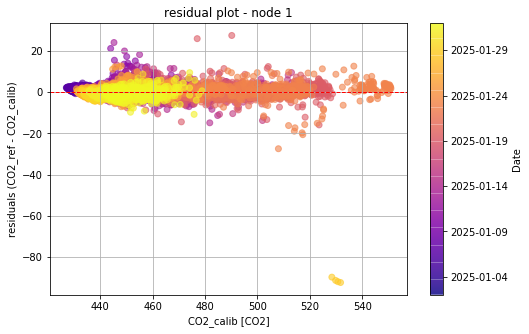

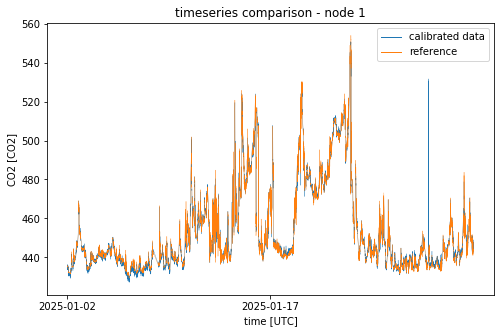

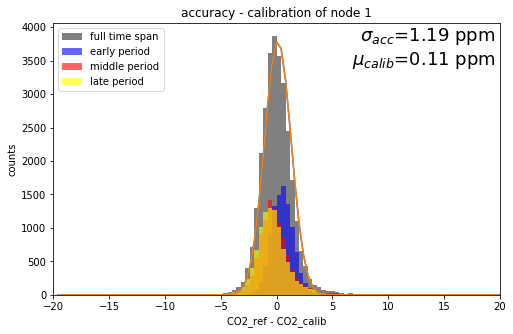

In [ ]:
"""
Analysefunktion für den Fit.

Funktion liegt in calibration.py
"""


gas_name = CONFIG["gas"]
analysis_results = calib_tool.analyze_calibration_results(
    vars=vars,
    gas_ref=gas_ref,
    params=params,
    errors=errors,
    covariance=covariance,
    cfg=CONFIG,
    fit_func=calib_tool.fit_multi_lin2,
    names = [f"a_{gas_name}", "a_p", "a_T", "a_T²", "a_RH", "drift", "y"] #Namen der Parameter
)



# Beispiel für Temp-Binning

Temperaturstatistik:
  Mittelwert : 8.92 °C
  Median     : 8.36 °C
  Standardabw: 4.52 °C
  Minimum    : -0.20 °C
  Maximum    : 23.06 °C


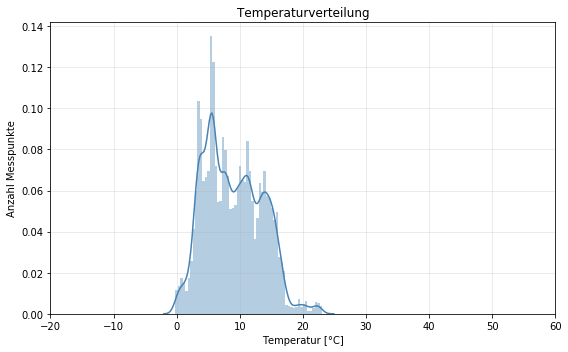

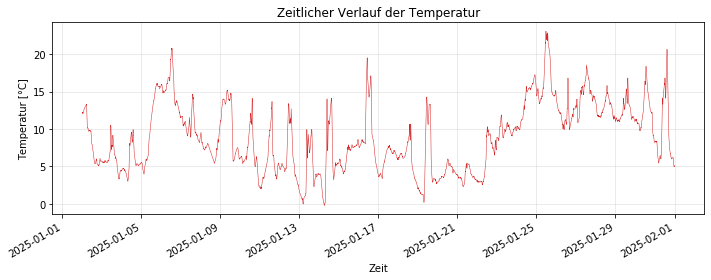

In [ ]:
"""
Temperaturanalyse des Datensatzes

liegt in temp_binning.py
"""


stats = calib_tool.analyze_temperature_distribution(T2, time)

In [ ]:
"""
Basic temperatur binning Funktion, nicht final

Manuelle einstellung der bins

liegt in temp_binning.py
"""


print("\n=== Temperatur-Binning ===")
gas_ref2, gas_raw2, p2, T2, rh2, time2 = calib_tool.apply_temperature_binning(
    gas_ref,gas_raw, p, T2, rh, 
    n_bins=CONFIG.get("n_temp_bins", 11),
    temp_range=CONFIG.get("temp_range", (3, 17))
)

vars2 = (gas_raw2, p2, T2, rh2, time2)


=== Temperatur-Binning ===


In [ ]:
params2, errors2, covariance2 = calib_tool.heidelberg_fitting_method(vars2, gas_ref2, CONFIG)



Performing Heidelberg fit...
Fit erfolgreich abgeschlossen.


Node 1 - Fitted Parameters:
a_CO2 = 1.0067 ± 0.0010
a_p = -0.1075 ± 0.0019
a_T = -0.0068 ± 0.0262
a_T² = 0.0009 ± 0.0012
a_RH = 0.0020 ± 0.0020
drift = 0.0594 ± 0.0000
y = 103.3971 ± 1.9965
$R^2$ = 0.9905
Covariance matrix:
 [[ 1.07150024e-06 -3.34458011e-07  5.74854742e-06 -1.94709248e-07
  -9.44216331e-08  0.00000000e+00 -1.78293179e-04]
 [-3.34458011e-07  3.60972495e-06  8.36293010e-06  5.74391128e-09
   1.87042910e-06  0.00000000e+00 -3.65529305e-03]
 [ 5.74854742e-06  8.36293010e-06  6.88285600e-04 -3.15279989e-05
   6.92435806e-06  0.00000000e+00 -1.45921519e-02]
 [-1.94709248e-07  5.74391128e-09 -3.15279989e-05  1.56237262e-06
   9.39125392e-08  0.00000000e+00  2.10205088e-04]
 [-9.44216331e-08  1.87042910e-06  6.92435806e-06  9.39125392e-08
   3.91001749e-06  0.00000000e+00 -2.14308595e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.78293179e-04 -3.65529305e-03 -1.45921519e-02  2.10205088e-04
  -2.14

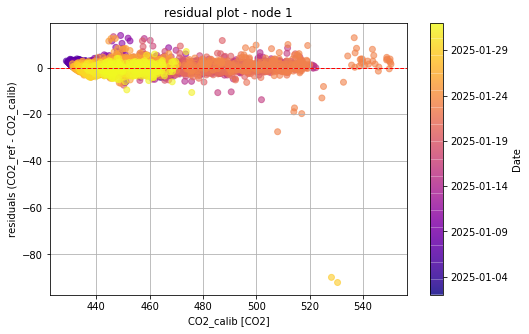

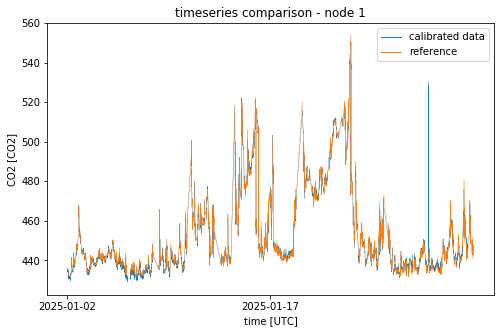

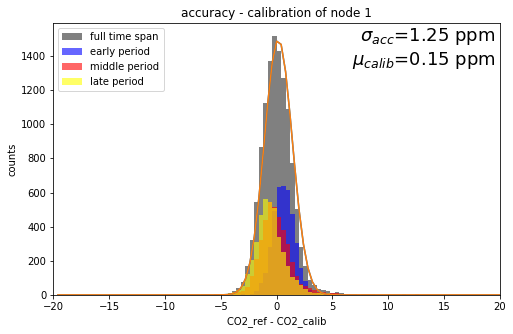

In [ ]:
analysis_results = calib_tool.analyze_calibration_results(
    vars=vars2,
    gas_ref=gas_ref2,
    params=params2,
    errors=errors2,
    covariance=covariance2,
    cfg=CONFIG,
    fit_func=calib_tool.fit_multi_lin2,
    names = [f"a_{gas_name}", "a_p", "a_T", "a_T²", "a_RH", "drift", "y"] #Namen der Parameter
)

# Output calibrated Dataset


## NOCH NICHT VERALLGEMEINERT FÜR BELIEBIGE GASE!!!



=== STEP 1: Import datasets ===
Importing datasets...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-15.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-16.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-17.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-18.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-19.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-20.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-21.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_data/unicorn01/DEnode1-2025_07_29-22.csv nicht gefunden. Überspringe...
Datei /net/dsvr-02/mnt/data2/UNICORN/raw_

/home/atmo/bin/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Resampling successful.

=== STEP 3: Compute dry CO2 ===

=== STEP 4: Skip alignment (measurement mode) ===

=== STEP 5: Apply calibration model ===


/home/atmo/bin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


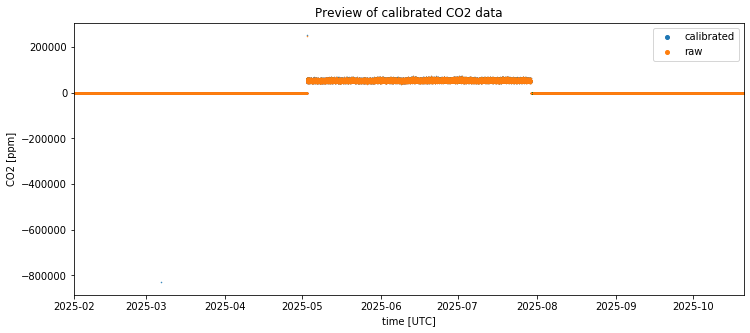


=== STEP 6: Export calibrated dataset ===

Calibration saved as:
- /home/tvoss/code/data/calibrated_data/unicorn1_bsp.cd
- /home/tvoss/code/data/calibrated_data/unicorn1_bsp.csv



In [ ]:
'''
Berechnet einen Kalibrierten Datensatz mit den gegebenen Parametern und speichert ihn als .csv
Zeitraum über CONFIG gegeben

noch nicht verallgemeinert

liegt in calibrate_dataset.py

(Plot sieht hier komisch aus aufgrund der fehlerhaften Daten zwischen Mai und August)
'''


calib_tool.create_calibrated_dataset(CONFIG, *params2, acc= analysis_results,fit_func=calib_tool.fit_multi_lin2, filename = "_bsp", base_path="/home/tvoss/code/data/calibrated_data/")